In [53]:
# Load all regions' precipitation data
from pathlib import Path
import pandas as pd 
regions = ['midwest', 'northeast', 'south', 'west']
data_dir = Path('historical_data')

historical_precipitation = []
for region in regions:
    file_path = data_dir / f'{region}_historical_precipitation.csv'
    df = pd.read_csv(file_path)
    df['region'] = region
    historical_precipitation.append(df)

combined_df = pd.concat(historical_precipitation, ignore_index=True)

combined_df = combined_df.groupby('year')['pr'].mean().reset_index()
combined_df

,year,pr
0,1850,0.000025
1,1851,0.000028
2,1852,0.000029
3,1853,0.000029
4,1854,0.000030
...,...,...
160,2010,0.000029
161,2011,0.000029
162,2012,0.000031
163,2013,0.000030


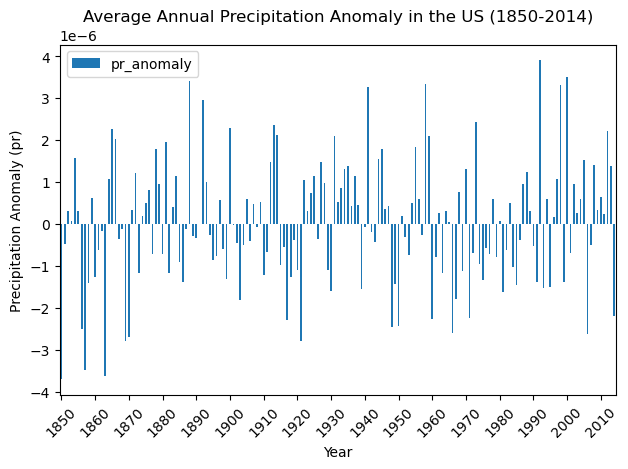

In [11]:
#plot precipitation anomaly using bar chart
combined_df['pr_anomaly'] = combined_df['pr'] - combined_df['pr'].mean()
combined_df.plot(x='year', y='pr_anomaly', kind='bar', title='Average Annual Precipitation Anomaly in the US (1850-2014)')
xticks = combined_df.index[::10]
xlabels = combined_df['year'][::10]
import matplotlib.pyplot as plt
plt.xticks(xticks, xlabels, rotation=45)
plt.xlabel('Year')
plt.ylabel('Precipitation Anomaly (pr)')
plt.tight_layout()
plt.show()

In [56]:
# Keep the data for every 10 years starting from 1850
plot_df = combined_df[combined_df['year'] % 10 == 0]
plot_df = plot_df[combined_df['year'] >= 1850].reset_index(drop=True)
plot_df.to_csv('pr_1850_2010.csv', index=False)

/var/folders/cp/r3mkdy4d00l77xvrwh1q87nw0000gn/T/ipykernel_49407/2267685133.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



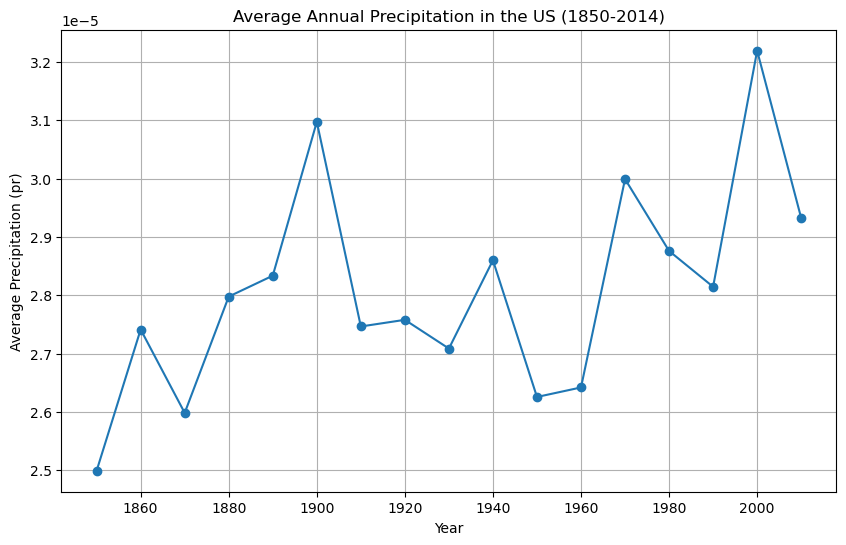

In [8]:
# Plot the pr for only every 10 years
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(plot_df['year'], plot_df['pr'], marker='o')
plt.title('Average Annual Precipitation in the US (1850-2014)')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (pr)')
plt.grid()
plt.show()

In [32]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from pathlib import Path

# Load all regional data files
regions = ['midwest', 'northeast', 'south', 'west']
data_dir = Path('future_data')

# Load and combine all regional data
all_data = []
for region in regions:
    df = pd.read_csv(data_dir / f'{region}_futures_merged.csv')
    df['region'] = region
    all_data.append(df)

# Combine all regions
combined_df = pd.concat(all_data, ignore_index=True)

# Calculate average precipitation across all regions for each year
avg_precip = combined_df.groupby('year').agg({
    'low_emissions_pr': 'mean',
    'high_emissions_pr': 'mean'
}).reset_index()

# Filter for years 2025-2100
avg_precip = avg_precip[(avg_precip['year'] >= 2015) & (avg_precip['year'] <= 2100)]

# Unit conversion factor
CONVERSION_FACTOR = 1000 

avg_precip['low_emissions_pr_mm'] = avg_precip['low_emissions_pr'] * CONVERSION_FACTOR
avg_precip['high_emissions_pr_mm'] = avg_precip['high_emissions_pr'] * CONVERSION_FACTOR

# Create the line chart
fig = go.Figure()

# Add SSP1-2.6 (low emission) line
fig.add_trace(go.Scatter(
    x=avg_precip['year'],
    y=avg_precip['low_emissions_pr_mm'],
    mode='lines',
    name='SSP1-2.6 (Low Emission)',
    line=dict(color='#2E86AB', width=3),
    hovertemplate='<b>SSP1-2.6</b><br>' +
                  'Year: %{x}<br>' +
                  'Precipitation: %{y:.2f} mm/year<extra></extra>'
))

# Add SSP5-8.5 (high emission) line
fig.add_trace(go.Scatter(
    x=avg_precip['year'],
    y=avg_precip['high_emissions_pr_mm'],
    mode='lines',
    name='SSP5-8.5 (High Emission)',
    line=dict(color='#A23B72', width=3),
    hovertemplate='<b>SSP5-8.5</b><br>' +
                  'Year: %{x}<br>' +
                  'Precipitation: %{y:.2f} mm/year<extra></extra>'
))

# Add ribbon/fill between the lines to show divergence
fig.add_trace(go.Scatter(
    x=avg_precip['year'].tolist() + avg_precip['year'].tolist()[::-1],
    y=avg_precip['low_emissions_pr_mm'].tolist() + avg_precip['high_emissions_pr_mm'].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(162, 59, 114, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo='skip',
    showlegend=False,
    name='Divergence'
))

# Update layout
fig.update_layout(
    title={
        'text': 'U.S. Average Precipitation Projection (2025-2100)',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    },
    xaxis=dict(
        title='Year',
        titlefont=dict(size=14),
        tickfont=dict(size=12),
        range=[2025, 2100]
    ),
    yaxis=dict(
        title='Average Precipitation (mm/year)',
        titlefont=dict(size=14),
        tickfont=dict(size=12)
    ),
    hovermode='x unified',
    legend=dict(
        x=0.02,
        y=0.98,
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='rgba(0, 0, 0, 0.2)',
        borderwidth=1
    ),
    plot_bgcolor='white',
    width=1000,
    height=600,
    margin=dict(l=80, r=50, t=80, b=60)
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='rgba(0,0,0,0.1)')

fig.show()


In [57]:
avg_precip

,year,low_emissions_pr,high_emissions_pr,low_emissions_pr_mm,high_emissions_pr_mm
0,2015,0.000030,0.000032,0.029521,0.031844
1,2016,0.000029,0.000031,0.028707,0.030668
2,2017,0.000029,0.000030,0.029037,0.030256
3,2018,0.000031,0.000027,0.031469,0.026827
4,2019,0.000034,0.000031,0.033656,0.030904
...,...,...,...,...,...
81,2096,0.000029,0.000034,0.029436,0.034237
82,2097,0.000025,0.000033,0.025495,0.032558
83,2098,0.000035,0.000031,0.035326,0.031018
84,2099,0.000033,0.000029,0.033326,0.028538


In [60]:
avg_precip_overview = avg_precip[avg_precip['year']%10 == 0]
avg_precip_overview[['year','low_emissions_pr']].to_csv('projected_low_2025_2100.csv', index=False)

In [61]:
avg_precip_overview[['year','high_emissions_pr']].to_csv('projected_high_2025_2100.csv', index=False)

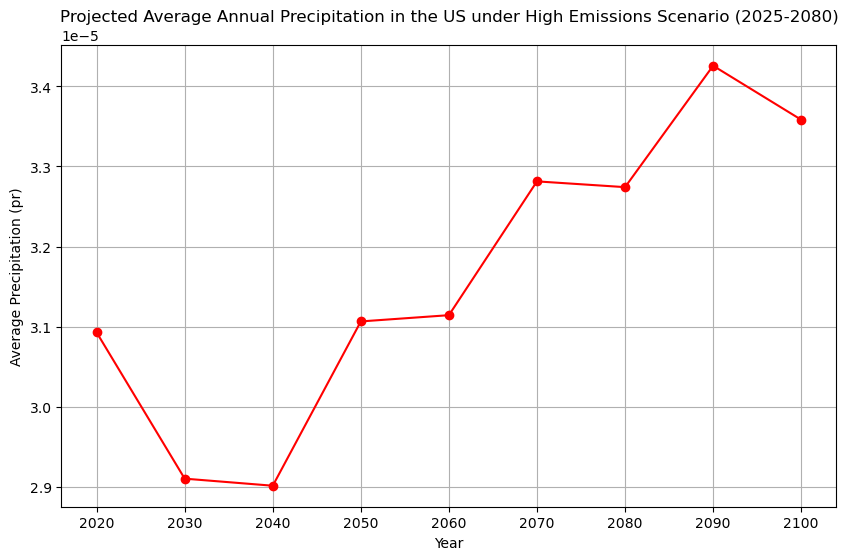

In [34]:
avg_precip_overview = avg_precip[avg_precip['year']%10 == 0]

# plot the overview for high emissions
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(avg_precip_overview['year'], avg_precip_overview['high_emissions_pr'], marker='o', color='red')
plt.title('Projected Average Annual Precipitation in the US under High Emissions Scenario (2025-2080)')
plt.xlabel('Year')
plt.ylabel('Average Precipitation (pr)')
plt.grid()
plt.show()


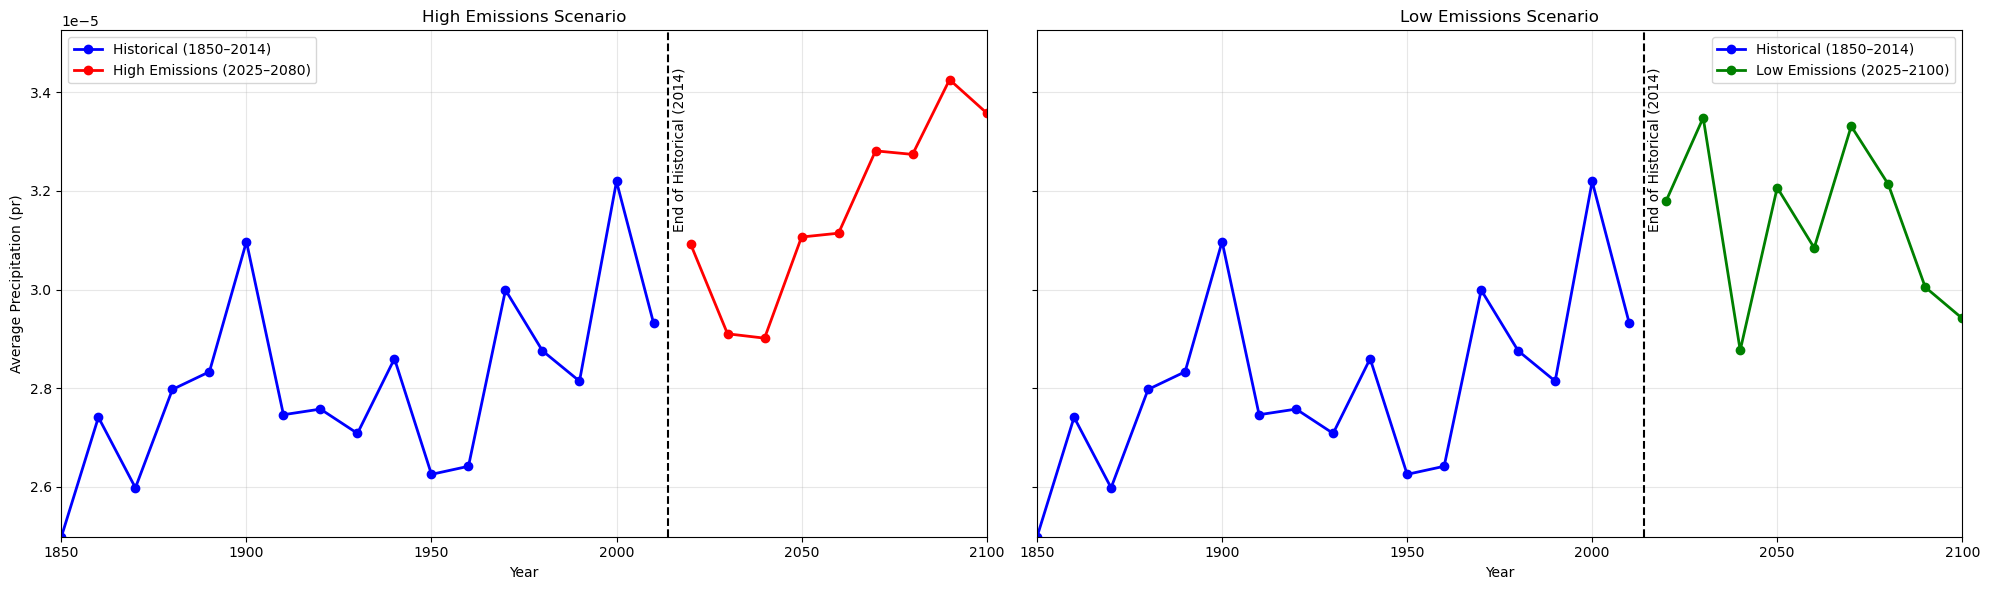

In [50]:
import matplotlib.pyplot as plt

# --- Create shared figure ---
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True, sharey=True)

# --- Select every 10 years ---
avg_precip_overview = avg_precip[avg_precip['year'] % 10 == 0]

# ==========================================================
#  Plot 1 — High Emissions
# ==========================================================
axes[0].plot(
    plot_df['year'], plot_df['pr'],
    marker='o', color='blue', linewidth=2,
    label='Historical (1850–2014)'
)
axes[0].plot(
    avg_precip_overview['year'],
    avg_precip_overview['high_emissions_pr'],
    marker='o', color='red', linewidth=2,
    label='High Emissions (2025–2080)'
)

axes[0].axvline(2014, color='black', linestyle='--')
axes[0].text(2014+1, plot_df['pr'].max()*0.97,
             'End of Historical (2014)', rotation=90)

axes[0].set_title('High Emissions Scenario')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Precipitation (pr)')
axes[0].grid(alpha=0.3)
axes[0].legend()

# ==========================================================
#  Plot 2 — Low Emissions
# ==========================================================
axes[1].plot(
    plot_df['year'], plot_df['pr'],
    marker='o', color='blue', linewidth=2,
    label='Historical (1850–2014)'
)
axes[1].plot(
    avg_precip_overview['year'],
    avg_precip_overview['low_emissions_pr'],
    marker='o', color='green', linewidth=2,
    label='Low Emissions (2025–2100)'
)

axes[1].axvline(2014, color='black', linestyle='--')
axes[1].text(2014+1, plot_df['pr'].max()*0.97,
             'End of Historical (2014)', rotation=90)

axes[1].set_title('Low Emissions Scenario')
axes[1].set_xlabel('Year')
axes[1].grid(alpha=0.3)
axes[1].legend()

# ==========================================================
# Standardize axes automatically
# ==========================================================

# X-axis limits (same for both)
min_year = min(plot_df['year'].min(), avg_precip_overview['year'].min())
max_year = max(plot_df['year'].max(), avg_precip_overview['year'].max())
axes[0].set_xlim(min_year, max_year)
axes[1].set_xlim(min_year, max_year)

# Y-axis limits (same for both)
min_pr = min(plot_df['pr'].min(),
             avg_precip_overview['high_emissions_pr'].min(),
             avg_precip_overview['low_emissions_pr'].min())
max_pr = max(plot_df['pr'].max(),
             avg_precip_overview['high_emissions_pr'].max(),
             avg_precip_overview['low_emissions_pr'].max())
axes[0].set_ylim(min_pr, max_pr+0.1*1e-5)
axes[1].set_ylim(min_pr, max_pr+0.1*1e-5)

plt.tight_layout()
plt.show()



In [21]:
avg_precip['high_emissions_pr'] = avg_precip['high_emissions_pr'].where(avg_precip['year'].between(2025, 2080))
avg_precip['low_emissions_pr'] = avg_precip['low_emissions_pr'].where(avg_precip['year'].between(2025, 2080))

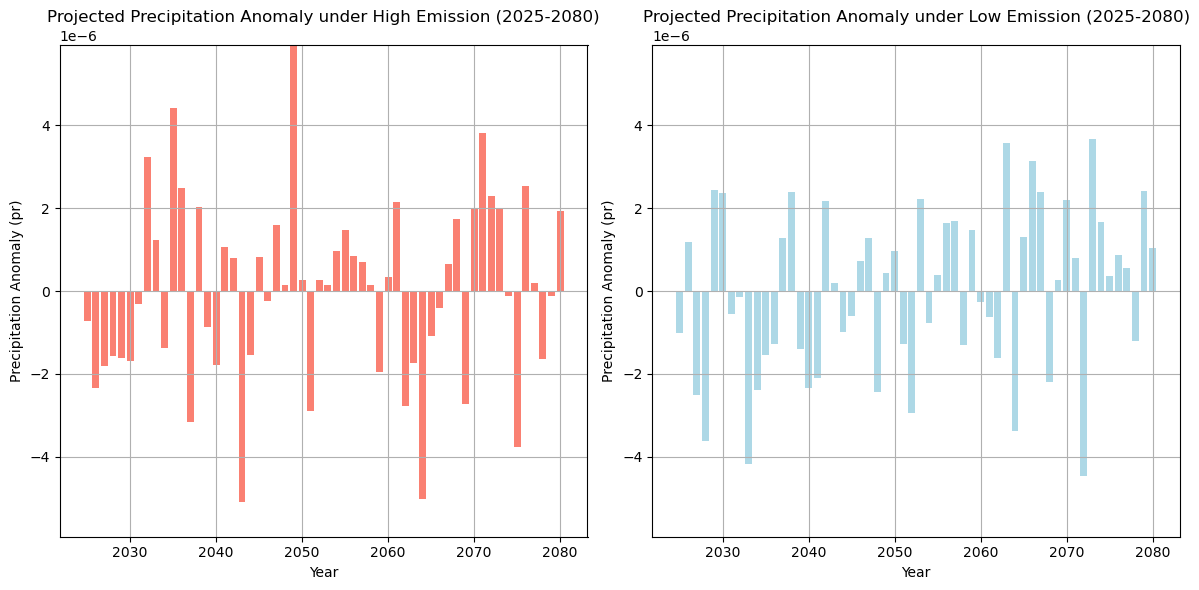

In [23]:
# plot the anomaly of future avg_precip['high_emissions_pr'] and avg_precip['low_emissions_pr'] for years 2025-2080
# plot it separately side by side using bar chart

import matplotlib.pyplot as plt

#make two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


# Plot the anomaly for high emissions scenario
avg_precip['pr_anomaly'] = avg_precip['high_emissions_pr'] - avg_precip['high_emissions_pr'].mean()
axs[0].bar(avg_precip['year'], avg_precip['pr_anomaly'], color='salmon', label='High Emission')
axs[0].set_title('Projected Precipitation Anomaly under High Emission (2025-2080)')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Precipitation Anomaly (pr)')
axs[0].grid()

# Plot the anomaly for low emissions scenario
avg_precip['pr_anomaly_low'] = avg_precip['low_emissions_pr'] - avg_precip['low_emissions_pr'].mean()
axs[1].bar(avg_precip['year'], avg_precip['pr_anomaly_low'], color='lightblue', label='Low Emission')
axs[1].set_title('Projected Precipitation Anomaly under Low Emission (2025-2080)')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Precipitation Anomaly (pr)')
axs[1].grid()

# standardize the y-axis for better comparison
max_anomaly = max(
    abs(avg_precip['pr_anomaly'].max()), 
    abs(avg_precip['pr_anomaly'].min()), 
    abs(avg_precip['pr_anomaly_low'].max()), 
    abs(avg_precip['pr_anomaly_low'].min())
)
axs[0].set_ylim(-max_anomaly, max_anomaly)
axs[1].set_ylim(-max_anomaly, max_anomaly)


plt.tight_layout()  
plt.show()

In [2]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
import numpy as np

# Load all regional data files
regions = ['midwest', 'northeast', 'south', 'west']
data_dir = Path('future_data')

# Load regional data
regional_data = {}
for region in regions:
    df = pd.read_csv(data_dir / f'{region}_futures_merged.csv')
    df = df[(df['year'] >= 2025) & (df['year'] <= 2100)].copy()
    CONVERSION_FACTOR = 1000
    df['low_emissions_pr_mm'] = df['low_emissions_pr'] * CONVERSION_FACTOR
    df['high_emissions_pr_mm'] = df['high_emissions_pr'] * CONVERSION_FACTOR
    regional_data[region] = df

# Calculate overall y-axis range for better scaling
all_low = np.concatenate([df['low_emissions_pr_mm'].values for df in regional_data.values()])
all_high = np.concatenate([df['high_emissions_pr_mm'].values for df in regional_data.values()])
y_min = min(all_low.min(), all_high.min())
y_max = max(all_low.max(), all_high.max())
y_range = [y_min * 0.95, y_max * 1.05]  # Add 5% padding

# Create small multiples with 2x2 grid
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Midwest', 'Northeast', 'South', 'West'),
    vertical_spacing=0.12,
    horizontal_spacing=0.10,
    shared_xaxes=True,
    shared_yaxes=False  # Don't share y-axes to allow each region to show its own scale
)

# Region positions in the grid
region_positions = {
    'midwest': (1, 1),
    'northeast': (1, 2),
    'south': (2, 1),
    'west': (2, 2)
}

# Add traces for each region
for region in regions:
    row, col = region_positions[region]
    df = regional_data[region]
    
    # Add low emission line
    fig.add_trace(
        go.Scatter(
            x=df['year'],
            y=df['low_emissions_pr_mm'],
            mode='lines',
            name='SSP1-2.6 (Low Emission)',
            line=dict(color='#2E86AB', width=2.5),
            showlegend=(row == 1 and col == 1),  # Only show legend for first subplot
            hovertemplate=f'<b>{region.title()}</b><br>SSP1-2.6<br>Year: %{{x}}<br>Precipitation: %{{y:.3f}} mm/year<extra></extra>'
        ),
        row=row, col=col
    )
    
    # Add high emission line
    fig.add_trace(
        go.Scatter(
            x=df['year'],
            y=df['high_emissions_pr_mm'],
            mode='lines',
            name='SSP5-8.5 (High Emission)',
            line=dict(color='#A23B72', width=2.5),
            showlegend=(row == 1 and col == 1),  # Only show legend for first subplot
            hovertemplate=f'<b>{region.title()}</b><br>SSP5-8.5<br>Year: %{{x}}<br>Precipitation: %{{y:.3f}} mm/year<extra></extra>'
        ),
        row=row, col=col
    )

# Update layout
fig.update_layout(
    title_text='Regional Precipitation Projections (2025-2100)',
    title_x=0.5,
    height=800,
    width=1200,
    plot_bgcolor='white',
    legend=dict(
        x=0.5,
        y=-0.05,
        xanchor='center',
        orientation='h',
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='rgba(0, 0, 0, 0.2)',
        borderwidth=1
    )
)

# Update x-axes (only bottom row needs labels)
fig.update_xaxes(
    title_text='Year',
    range=[2025, 2100],
    dtick=15,
    showgrid=True,
    gridcolor='rgba(0,0,0,0.1)',
    row=2, col=1
)
fig.update_xaxes(
    title_text='Year',
    range=[2025, 2100],
    dtick=15,
    showgrid=True,
    gridcolor='rgba(0,0,0,0.1)',
    row=2, col=2
)
fig.update_xaxes(
    range=[2025, 2100],
    dtick=15,
    showgrid=True,
    gridcolor='rgba(0,0,0,0.1)',
    row=1, col=1
)
fig.update_xaxes(
    range=[2025, 2100],
    dtick=15,
    showgrid=True,
    gridcolor='rgba(0,0,0,0.1)',
    row=1, col=2
)

# Update y-axes with tight ranges for each region
for i, region in enumerate(regions):
    row = (i // 2) + 1
    col = (i % 2) + 1
    df = regional_data[region]
    
    # Calculate region-specific range with minimal padding
    region_min = min(df['low_emissions_pr_mm'].min(), df['high_emissions_pr_mm'].min())
    region_max = max(df['low_emissions_pr_mm'].max(), df['high_emissions_pr_mm'].max())
    
    # Use very tight padding (1% on each side) and ensure range is reasonable
    padding = (region_max - region_min) * 0.1  # 10% of the data range as padding
    if padding < 0.001:  # If range is very small, use fixed small padding
        padding = 0.001
    
    region_range = [max(0, region_min - padding), region_max + padding]
    
    fig.update_yaxes(
        title_text='Precipitation (mm/year)' if col == 1 else '',
        range=region_range,
        showgrid=True,
        gridcolor='rgba(0,0,0,0.1)',
        row=row, col=col
    )

fig.show()


In [3]:
import pandas as pd
import plotly.graph_objects as go
from pathlib import Path

# Load historical data to calculate baseline (1981-2010)
regions = ['midwest', 'northeast', 'south', 'west']
historical_dir = Path('historical_data')
future_dir = Path('future_data')

# Calculate baseline precipitation (1981-2010 average) for each region
baseline_data = {}
for region in regions:
    hist_df = pd.read_csv(historical_dir / f'{region}_historical_precipitation.csv')
    baseline_df = hist_df[(hist_df['year'] >= 1981) & (hist_df['year'] <= 2010)]
    baseline_avg = baseline_df['pr'].mean()
    baseline_data[region] = baseline_avg * 1000  # Convert to mm/year

# Load future data and calculate average for 2080-2100 (end of century)
future_data = {}
for region in regions:
    future_df = pd.read_csv(future_dir / f'{region}_futures_merged.csv')
    future_df = future_df[(future_df['year'] >= 2080) & (future_df['year'] <= 2100)]
    
    # Convert to mm/year
    CONVERSION_FACTOR = 1000
    low_emissions_avg = future_df['low_emissions_pr'].mean() * CONVERSION_FACTOR
    high_emissions_avg = future_df['high_emissions_pr'].mean() * CONVERSION_FACTOR
    
    # Calculate percentage change relative to baseline
    baseline = baseline_data[region]
    low_change_pct = ((low_emissions_avg - baseline) / baseline) * 100
    high_change_pct = ((high_emissions_avg - baseline) / baseline) * 100
    
    future_data[region] = {
        'low_change_pct': low_change_pct,
        'high_change_pct': high_change_pct
    }

# Map regions to U.S. states (standard regional definitions)
region_to_states = {
    'midwest': ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI'],
    'northeast': ['CT', 'ME', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT'],
    'south': ['AL', 'AR', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV'],
    'west': ['AZ', 'CA', 'CO', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA', 'WY']
}

# Create state-level dataframes for both scenarios
states_low = []
states_high = []

for region, states in region_to_states.items():
    low_change = future_data[region]['low_change_pct']
    high_change = future_data[region]['high_change_pct']
    
    for state in states:
        states_low.append({'state': state, 'change_pct': low_change, 'scenario': 'SSP1-2.6'})
        states_high.append({'state': state, 'change_pct': high_change, 'scenario': 'SSP5-8.5'})

df_low = pd.DataFrame(states_low)
df_high = pd.DataFrame(states_high)

# Calculate common color scale range for both maps
all_changes = list(df_low['change_pct']) + list(df_high['change_pct'])
z_min = min(all_changes)
z_max = max(all_changes)
# Ensure symmetric range around zero for better visualization
abs_max = max(abs(z_min), abs(z_max))
z_range = [-abs_max, abs_max]

# Create side-by-side choropleth maps using domain parameter
fig = go.Figure()

# Add SSP1-2.6 map (left side)
fig.add_trace(
    go.Choropleth(
        locations=df_low['state'],
        z=df_low['change_pct'],
        locationmode='USA-states',
        colorscale='RdBu_r',
        zmin=z_range[0],
        zmax=z_range[1],
        zmid=0,
        colorbar=dict(
            title="Change (%)",
            x=0.45,
            len=0.5,
            y=0.5,
            yanchor='middle',
            thickness=15
        ),
        hovertemplate='<b>%{location}</b><br>' +
                      'Change: %{z:.1f}%<br>' +
                      'Scenario: SSP1-2.6<extra></extra>',
        name='SSP1-2.6',
        geo='geo'
    )
)

# Add SSP5-8.5 map (right side)
fig.add_trace(
    go.Choropleth(
        locations=df_high['state'],
        z=df_high['change_pct'],
        locationmode='USA-states',
        colorscale='RdBu_r',
        zmin=z_range[0],
        zmax=z_range[1],
        zmid=0,
        colorbar=dict(
            title="Change (%)",
            x=1.02,
            len=0.5,
            y=0.5,
            yanchor='middle',
            thickness=15
        ),
        hovertemplate='<b>%{location}</b><br>' +
                      'Change: %{z:.1f}%<br>' +
                      'Scenario: SSP5-8.5<extra></extra>',
        name='SSP5-8.5',
        geo='geo2'
    )
)

# Update layout with two geo subplots
fig.update_layout(
    title_text='U.S. Precipitation Change: Baseline (1981-2010) vs Future (2080-2100)',
    title_x=0.5,
    title_font_size=18,
    geo=dict(
        scope='usa',
        projection=go.layout.geo.Projection(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)',
        showframe=False,
        domain=dict(x=[0, 0.48], y=[0, 1]),
        center=dict(lon=-95, lat=38)
    ),
    geo2=dict(
        scope='usa',
        projection=go.layout.geo.Projection(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)',
        showframe=False,
        domain=dict(x=[0.52, 1], y=[0, 1]),
        center=dict(lon=-95, lat=38)
    ),
    height=600,
    width=1400,
    margin=dict(l=0, r=0, t=80, b=0)
)

# Add annotations for subplot titles
fig.add_annotation(
    text='SSP1-2.6 (Low Emissions)',
    x=0.24,
    y=1.05,
    xref='paper',
    yref='paper',
    showarrow=False,
    font=dict(size=14, color='black')
)

fig.add_annotation(
    text='SSP5-8.5 (High Emissions)',
    x=0.76,
    y=1.05,
    xref='paper',
    yref='paper',
    showarrow=False,
    font=dict(size=14, color='black')
)

fig.show()
